## # Data Compliance Check for applying MCMC

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

When using [Markov Chain Monte Carlo](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) (MCMC) for generating a representative sample, there are several important criteria and characteristics of your training data you should check:
1. **Stationarity** - Your data should come from a [stationary distribution](https://stats.stackexchange.com/questions/88256/what-does-sampling-period-mean-in-mcmc). Time series data should not have trends or seasonality that would affect the underlying distribution you're trying to sample from.
2. **Sufficient data volume** - You need enough data to accurately estimate the target distribution. Sparse datasets can lead to poor MCMC performance.
3. **Representativeness** - Your training data should [adequately cover the full distribution](https://bookdown.org/ajkurz/DBDA_recoded/markov-chain-monte-carlo.html) you're trying to sample from, including rare events or edge cases.
4. **Dimensionality** - Consider the [dimensionality](https://mathoverflow.net/questions/277623/does-mcmc-overcome-the-curse-of-dimensionality_ of your problem. High-dimensional spaces can suffer from the \"curse of dimensionality,\" making MCMC less efficient.
5. **Correlation structure** - [Understand the correlation structure](https://stats.stackexchange.com/questions/81744/specifying-the-correlation-structure-of-an-unevely-spaced-time-series-in-gee-wit) in your data. Highly correlated variables can slow down MCMC convergence.
6. **Multimodality** - Check if your distribution has multiple modes. [Multimodal distributions](https://arxiv.org/html/2501.05908v1) can trap MCMC chains in local optima.
7. **Boundary conditions** - Verify if your parameter space has [constraints or boundaries](https://www.simscale.com/docs/simwiki/numerics-background/what-are-boundary-conditions/) that need special handling in your MCMC implementation.
8. **Mixing properties** - Data that leads to good [mixing properties](https://stats.stackexchange.com/questions/223691/what-does-mixing-mean-in-sampling) is ideal for MCMC. Poor mixing means your chain takes longer to explore the full distribution.
9. **Prior knowledge** - Consider whether you have [reliable prior information](https://towardsdatascience.com/understanding-kolmogorov-smirnov-ks-tests-for-data-drift-on-profiled-data-5c8317796f78/) that can be incorporated into your MCMC approach.
10. **Noise characteristics** - [Understand the noise profile](https://www.quora.com/What-is-noise-in-data-science-machine-learning) in your data, as this affects how you should set up your MCMC sampler."

In [67]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql import functions as F

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
# from rezaware.modules.etl.loader import sparkFile as file
from rezaware.modules.ml.mcmc import __propAttr__ as attr
from rezaware.modules.ml.mcmc import mcmcDataCompliance as mcmc
from rezaware.modules.etl.loader import sparkFile as file

''' restart initiate classes '''
if debug:
    import importlib
    mcmc = importlib.reload(mcmc)
    # file=importlib.reload(file)
    attr=importlib.reload(attr)

__desc__ = "MCMC data compliance tests"
''' class to read/write file data '''
clsFile = file.dataWorkLoads(
    desc = __desc__,
    f_store_mode='local-fs',
    f_store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
    )
# ''' class to run the compliance tests '''
# clsTest = mcmc.dataWorkLoads(
#     desc=__desc__,
#     f_store_mode='local-fs',
#     f_store_root=proj_dir.split('mining/')[0],
#     )

print("n%s class initialization and load complete!" % __desc__)


All functional MCMCDATACOMPLIANCE-libraries in EVALUATION-package of BUDGET-module imported successfully!
All functional __PROPATTR__-libraries in EVALUATION-package of BUDGET-module imported successfully!
__propAttr__ Class initialization complete
__propAttr__ Class initialization complete
sparkFile Class initialization complete
rwAdsData Class initialization complete
__propAttr__ Class initialization complete
mcmcDataCompliance Class initialization complete
nMCMC data compliance tests class initialization and load complete!


## Load data

In [3]:
_fpath = "mining/data/budget/"
_fname = "FullDataset.csv"

__def_date_attr__="updated_time"
__def_realm__='OBJECTIVE'
__def_obj__ = 'OUTCOME_LEADS'

kwargs = {
    "REALMFILTATTR" : 'objective',
    "REALMFILTLIST" : [__def_obj__],
    "UNIXTIMESTAMP" : __def_date_attr__,
}
sdf = clsFile.read_realm(
    realm = __def_realm__,
    to_date = None,
    from_date=None,
    fname = _fname,
    fpath = _fpath,
    **kwargs,
)
print("Loaded %s %d rows" % (_fname, sdf.count()))# sdf.printSchema()/n"
numeric_cols = [c for c, t in sdf.dtypes if t.startswith('string')==False and t.startswith('bool')==False ]
", ".join(numeric_cols)
sdf = sdf.fillna(0,subset=numeric_cols)
print("Replaced NaN with 0 in %d columns" % len(numeric_cols))

25/03/11 17:43:38 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/03/11 17:43:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/11 17:43:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/11 17:44:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 425:=============================================>           (4 + 1) / 5]

Loaded FullDataset.csv 58280 rows
Replaced NaN with 0 in 38 columns


## Filter by Objective and Opimization Goal

In [ ]:
__def_obj_col__ = 'objective'
__def_opt_goal__= 'checkout'  # action group
__def_dt_cols__ = [f"unix_{__def_date_attr__}", __def_date_attr__]
__def_ad_met_cols__ = ['spend','impressions', 'clicks', 'reach', 
                       'frequency', 'CTR', 'CPP', 'CPC', 'CPM']
__def_roas_cols__ = ['purchase_value', 'purchase_roas']

_goal_act_cols = [x for x in sdf.columns
                  if x.find(__def_opt_goal__)==0
                  and x not in [*__def_ad_met_cols__, 
                                *__def_dt_cols__,
                                *__def_roas_cols__]]

''' Remove goal action cols not greater than zero '''
count_dict= {}
for act  in _goal_act_cols:
    count_dict[act]=sdf.select(act).dropna().count()

_act_met_cols_lst = [k for k,v in count_dict.items() if v>0]
_act_met_cols_lst

''' select data for relevant columns '''
_obj_goal_sdf=sdf.select(*__def_dt_cols__, __def_obj_col__,
                         *__def_roas_cols__, *__def_ad_met_cols__,
                         *_act_met_cols_lst)\
                .orderBy(*__def_dt_cols__)

print("Filtered object and goal data with %d rows and %d columns" 
      % (_obj_goal_sdf.count(), len(_obj_goal_sdf.columns)))

## Drop columns:
* Irrelevant
* Highly correlated
* Convert dates to unit timestamp

In [71]:
_drop_cols = ['updated_time', 'objective', 'account_currency', 'business_country_code',
              'business_city', 'business_state', 'timezone_name', 'account_id', 'ad_id',
              'adset_id', 'd1_view', 'd7_view', 'd28_view', 'd1_click', 'd7_click',
              'd28_click', 'frequency', 'CTR', 'CPP', 'CPC', 'CPM', 'purchase_value',
              'purchase_roas', 'reach'
             ]
_obj_goal_sdf = _obj_goal_sdf.drop(*_drop_cols)

_obj_goal_sdf.printSchema()

root
 |-- unix_updated_time: long (nullable = true)
 |-- spend: double (nullable = false)
 |-- impressions: integer (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- checkout_offsite_conversion__fb_pixel_add_to_cart: double (nullable = false)
 |-- checkout_offsite_conversion__fb_pixel_initiate_checkout: double (nullable = false)
 |-- checkout_offsite_conversion__fb_pixel_add_payment_info: double (nullable = false)



## Run Checks

In [72]:
''' 
['stationarity', 'data volume', 'representativeness', 'dimensionality', 
'correlation structure', 'multimodality', 'boundary conditions',
'mixing properties', 'prior knowledge', 'noise characteristics']
'''
_check_lst = ['stationarity', 'data volume', 'representativeness', 'dimensionality', 
              'correlation structure', 'multimodality', 'boundary conditions',
              'mixing properties', 'prior knowledge', 'noise characteristics']

test_results = clsTest.run_checks(
    data = _obj_goal_sdf,
    checks= _check_lst,
    multivariate=True,
    time_series =True
)

_plots = [x for x in test_results if 'plot' in x.keys() and x['plot'] is not None]
print("Results for %d checks with %d plots" 
      % (len(test_results), len(_plots)))
# ''' print plots '''
# for x in test_results:
#     if "plot" in x.keys():
#         print(x['check'], x['plot'], type(x['plot']))

running STATIONARITY check ...
running DATA VOLUME check ...
running REPRESENTATIVENESS check ...
running DIMENSIONALITY check ...
running CORRELATION STRUCTURE check ...
running MULTIMODALITY check ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


running BOUNDARY CONDITIONS check ...
running MIXING PROPERTY check ...
running PRIOR KNOWLEDGE check ...
running NOISE CHARACTERISTICS check ...

Finished running checks!
Results for 10 checks with 5 plots


## Explain and plot results



  check: stationary
  p_value: 1.0
  explained: ✗ Data does not appear to be stationary
  comply: False


  check: data volume
  samples: 58280
  explained: ✓ Data volume is likely sufficient (>= 1000 samples)
  comply: True


  check: representativeness
  comply: None
  plot: Figure(1000x600)


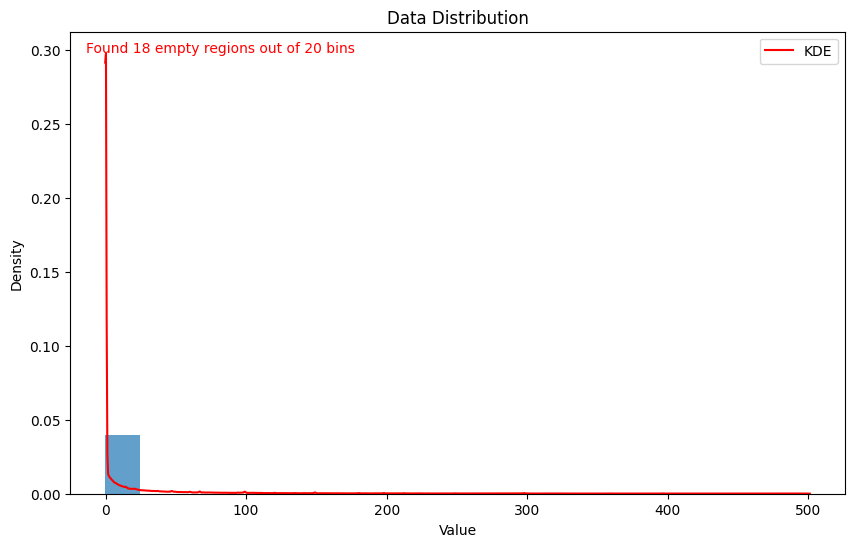

  explain: Note: Using PCA first component for representativeness visualization.
empty_regions': 18,  nan_percentage: -600.0,
valid_data': True, bin_edges': [-2.54328185e-01  2.48170535e+01  4.98884352e+01  7.49598168e+01
  1.00031198e+02  1.25102580e+02  1.50173962e+02  1.75245343e+02
  2.00316725e+02  2.25388107e+02  2.50459489e+02  2.75530870e+02
  3.00602252e+02  3.25673634e+02  3.50745015e+02  3.75816397e+02
  4.00887779e+02  4.25959160e+02  4.51030542e+02  4.76101924e+02
  5.01173305e+02].
 Note: Visual inspection is recommended to ensure representativeness. 


  check: dimensionality
  comply: True
  explain: Data dimensionality: 7
✓ Dimensionality is manageable for standard MCMC. 


  check: correlation structure
  comply: False
  plot: Figure(1000x800)


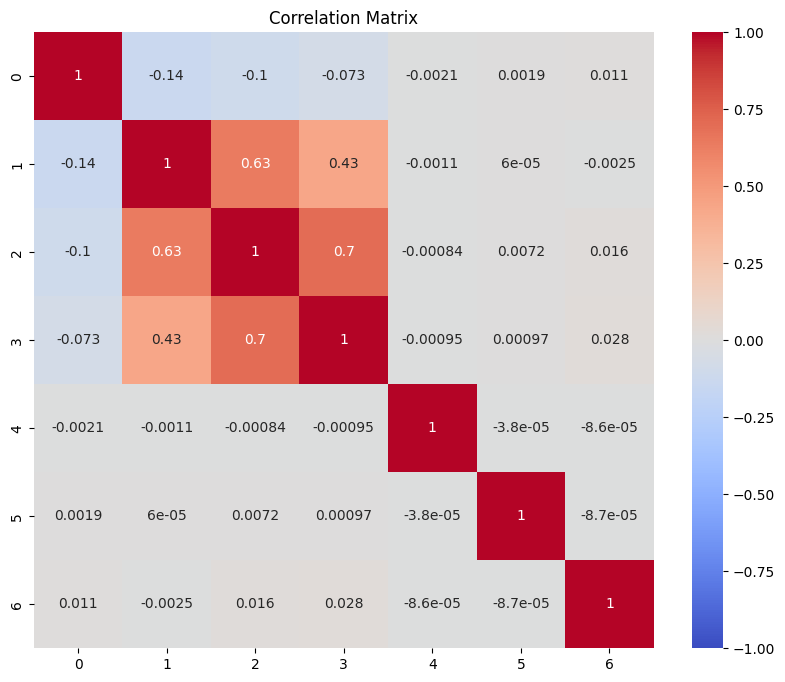

  explain: ✗ Found 1 pairs of highly correlated variables. High correlation may slow MCMC convergence. Note: Visual inspection is recommended to ensure representativeness. 


  check: multimodality
  comply: False
  plot: Figure(1000x600)


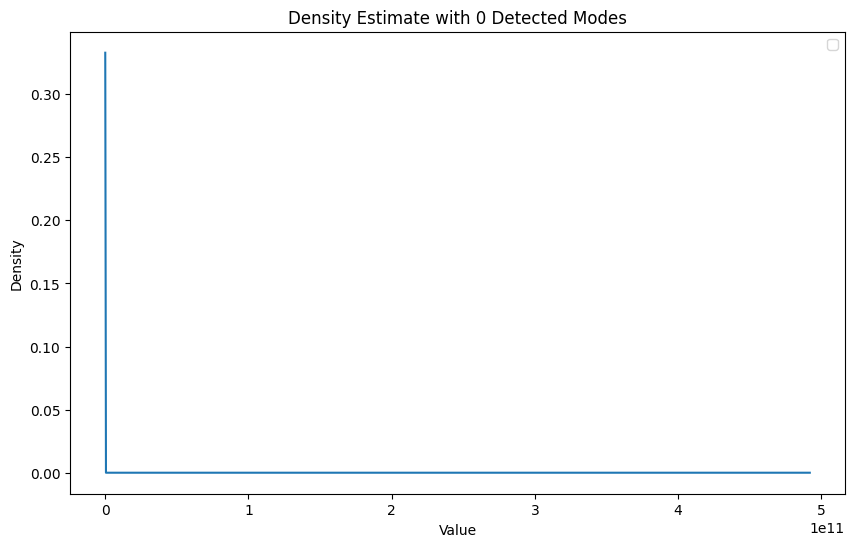

  explain: ✓ Distribution appears to be unimodal 


  check: boundary conditions
  comply: False
  plot: None
  explain: Potential boundary conditions: Data range: [0.0, 491999334492.0]. ✗ Data contains values very close to 0. Boundary constraints may require specialized MCMC. ✗ Data contains values very close to 1. Boundary constraints may require specialized MCMC. 


  check: mixing properties
  comply: True
  plot: Figure(1000x600)


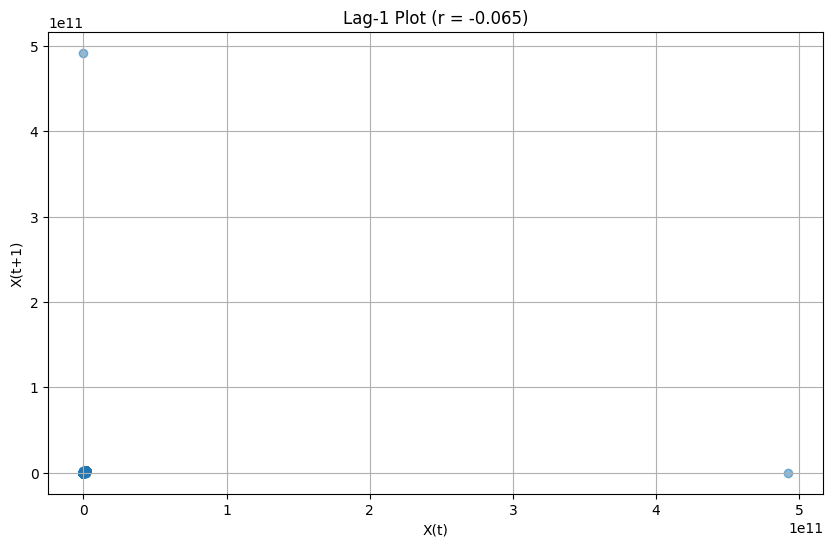

  explain: ✓ Lag-1 autocorrelation is moderate: -0.065. Mixing properties look reasonable. 


  check: prior knowledge
  comply: False
  plot: None
  explain: Distribution fitting results (higher p-value = better fit): (1) Normal: p-value = 0.0000, KS statistic = 0.4572. (2) Student-t 5df: p-value = 0.0000, KS statistic = 0.4522. (3) Student-t 10df: p-value = 0.0000, KS statistic = 0.4547. (4) Cauchy: p-value = 0.0000, KS statistic = 0.4362. (5) Laplace: p-value = 0.0000, KS statistic = 0.4691. (6) Logistic: p-value = 0.0000, KS statistic = 0.4368. (7) Poisson: p-value = 0.0000, KS statistic = 0.8571. 
Based on your data, consider priors related to the Normal distribution. ✗ No common distribution fits well (all p-values < 0.05). Consider non-parametric or mixture priors. 


  check: noise characteristics
  comply: False
  plot: Figure(1000x1200)


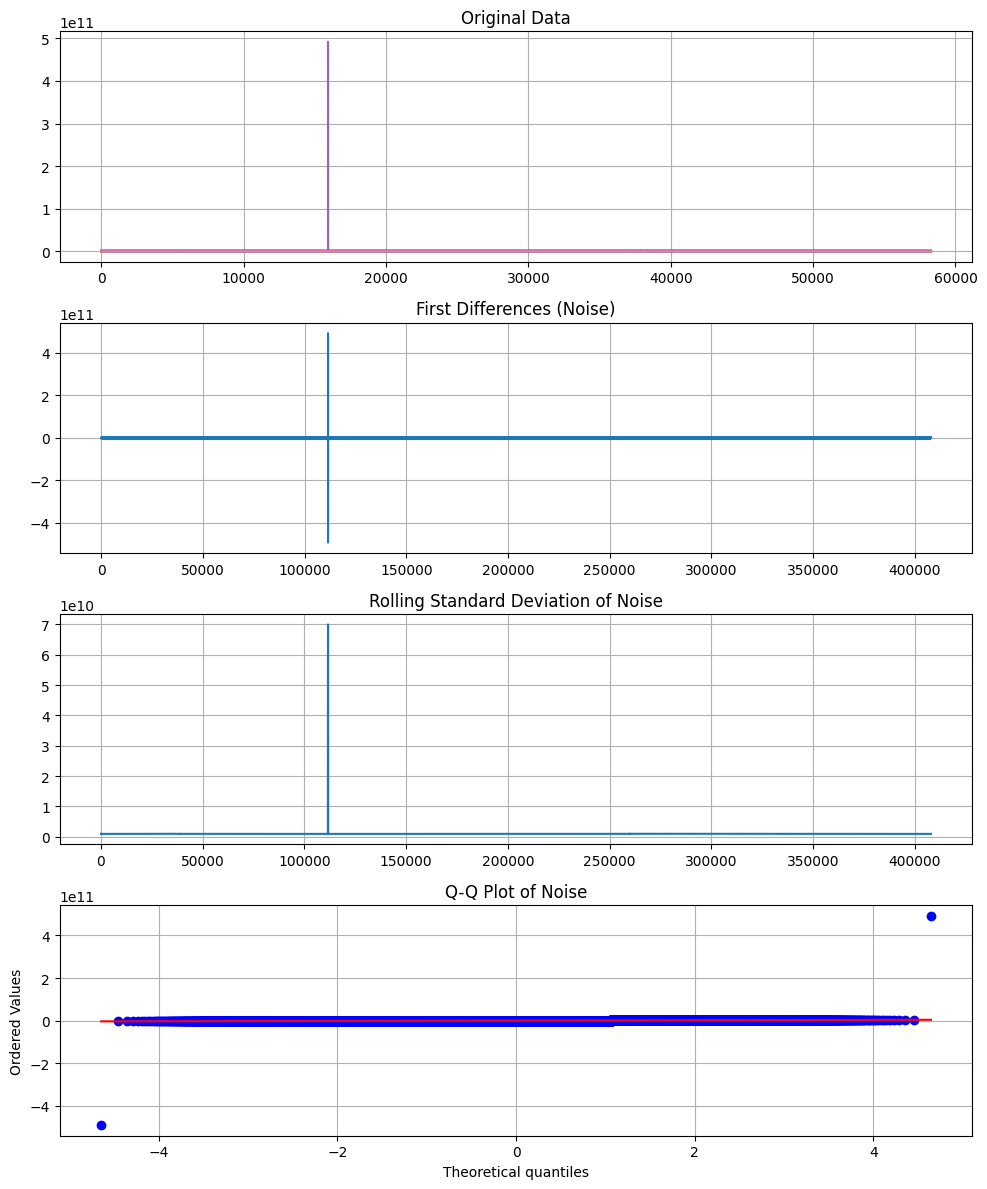

  explain: ✗ Heteroskedasticity detected (std ratio: 75.69). Consider: (i) Transformation to stabilize variance, (ii) MCMC methods that account for varying noise. ✗ Noise is not normally distributed (p-value: 0.0000).   Consider MCMC likelihood functions that match your noise distribution. 


In [73]:
from IPython.display import display

for _dict in test_results:
    print("\n")
    # Iterate through the keys that exist in this dictionary
    for k,v in _dict.items():
        # value = _dict[key]
        if k!='data': print(f"  {k}: {v}")
# for x in test_results:
#     print(x.items())
        if k=="plot" and v is not None:
            # print(x['check'], x['plot'], type(x['plot']))
            display(v)
if len(_plots)>0:
    plt.figure(x['plot'].number)  # Make the figure active
    plt.show()  # Display it"